In [3]:
from collections import defaultdict
import csv
import sys

import cv2
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
import numpy as np
import tifffile as tiff

csv.field_size_limit(sys.maxsize);

In [4]:
import operator
import numpy as np
from osgeo import gdal, gdal_array, osr, gdalnumeric
import shapefile
try:
    import Image
    import ImageDraw
except:
    from PIL import Image, ImageDraw
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist

In [55]:
raster_path  = '/home/dilara/project2/sentinel/super_cropped.tif'# Moscow
#raster_path  = '/home/dilara/project2/3done.tif'                 # NY
srcArray = gdal_array.LoadFile(raster_path)
srcImage = gdal.Open(raster_path)
geoTrans = srcImage.GetGeoTransform()
#shp_path =  '/home/dilara/project2/del'                          # NY
shp_path = "/home/dilara/project2/sentinel/buil_cropped_13_03"  # Moscow
r = shapefile.Reader("{}.shp".format(shp_path))

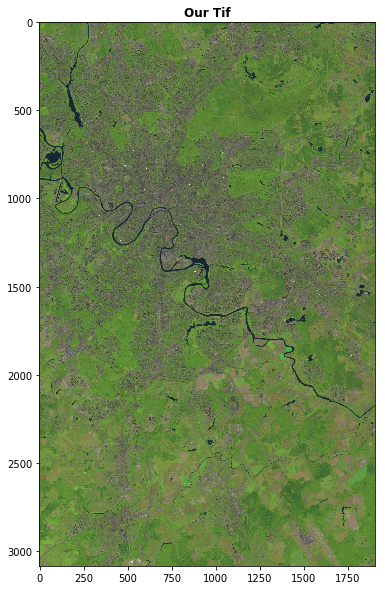

In [56]:
plt.figure(figsize=(10,10))
with rio.open(raster_path) as src:
    bb = src.read()
show(bb, title="Our Tif")
plt.show()

an example of cropped shp file (the original shp of NY is HUUUUUUUGE)

<Figure size 1080x1080 with 0 Axes>

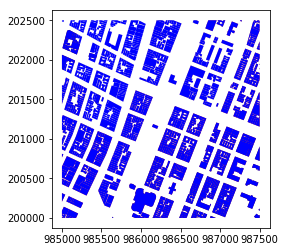

In [57]:
plt.figure(figsize=(15,15))
grid = gpd.read_file(shp_path + '.shp') #'/home/dilara/project2/res_tmp'
my_map = grid.plot(linewidth=0.1, cmap="Reds", scheme="quantiles", k=11, alpha=1)
grid.plot(ax=my_map, color="blue", linewidth=2.5)
plt.show()

In [58]:
g = geoTrans
g

(399960.0, 20.0, 0.0, 6200040.0, 0.0, -20.0)

In [59]:
minX, maxX, minY, maxY = g[0], (g[0] + srcImage.RasterXSize * g[1]), g[3], (g[3] + srcImage.RasterYSize * g[-1])
ulX, ulY, lrX, lrY = int(minX / g[1]), int(maxY / abs(g[-1])), int(maxX / g[1]), int(minY / abs(g[-1]))

In [60]:
pxWidth = int(lrX - ulX)
pxHeight = int(lrY - ulY)
clip = srcArray
print(pxWidth, pxHeight)

1904 3086


In [62]:
pixels = []
k = len(r)
rasterPoly2 = Image.new("L", (pxWidth, pxHeight), 1)
rasterize = ImageDraw.Draw(rasterPoly2)
for i in range(k):
    for p in r.shape(i).points:
            a1, a2 = ((p[0] - g[0]) / g[1]), ((g[3] - p[1]) / g[1])
            pixels.append((a1, a2))
    rasterize.polygon(pixels, 0)
    pixels = []

In [34]:
def imageToArray(i):
    """
    Converts a Python Imaging Library array to a gdal_array image.
    """
    a = gdal_array.numpy.frombuffer(i.tobytes(), 'b')
    a.shape = i.im.size[1], i.im.size[0]
    return a

In [63]:
mask = imageToArray(rasterPoly2)
mask

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int8)

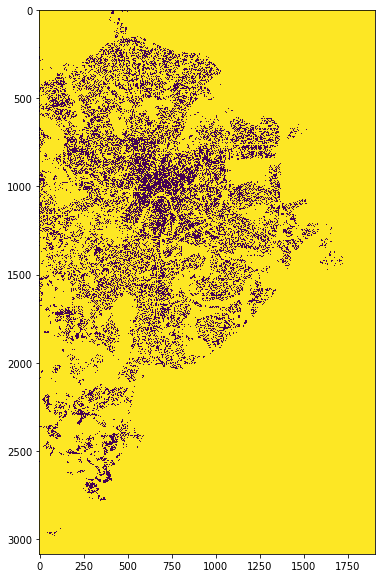

In [64]:
plt.figure(figsize=(10,10))
imshow(mask)
plt.show()

### Save tif mask

In [65]:
format = "GTiff"
driver = gdal.GetDriverByName( format )
metadata = driver.GetMetadata()
if gdal.DCAP_CREATE in metadata and metadata[ gdal.DCAP_CREATE ] == "YES":
    pass
else:
    print ("Driver %s does not support Create() method." % format)
    sys.exit( 1 )
# аналогично выполняется проверка для CreateCopy
if gdal.DCAP_CREATECOPY in metadata and metadata[ gdal.DCAP_CREATECOPY ] == "YES":
    pass
else:
    print ("Driver %s does not support CreateCopy() method." % format)
    sys.exit( 1 )

In [66]:
print(mask.shape)

(3086, 1904)


In [67]:
gtiffDriver = gdal.GetDriverByName( 'GTiff' )
dt = gdal.GDT_Byte
outClip = gtiffDriver.Create("/home/dilara/project2/tr.tif", mask.shape[1], mask.shape[0], 1, dt)

In [68]:
temp2 = outClip.ReadAsArray()
print(temp2.shape, mask.shape)

(3086, 1904) (3086, 1904)


In [69]:
outClip.SetProjection(srcImage.GetProjection() )
outClip.SetGeoTransform(srcImage.GetGeoTransform())

0

In [70]:
outClip.GetRasterBand( 1 ).WriteArray( mask)

0

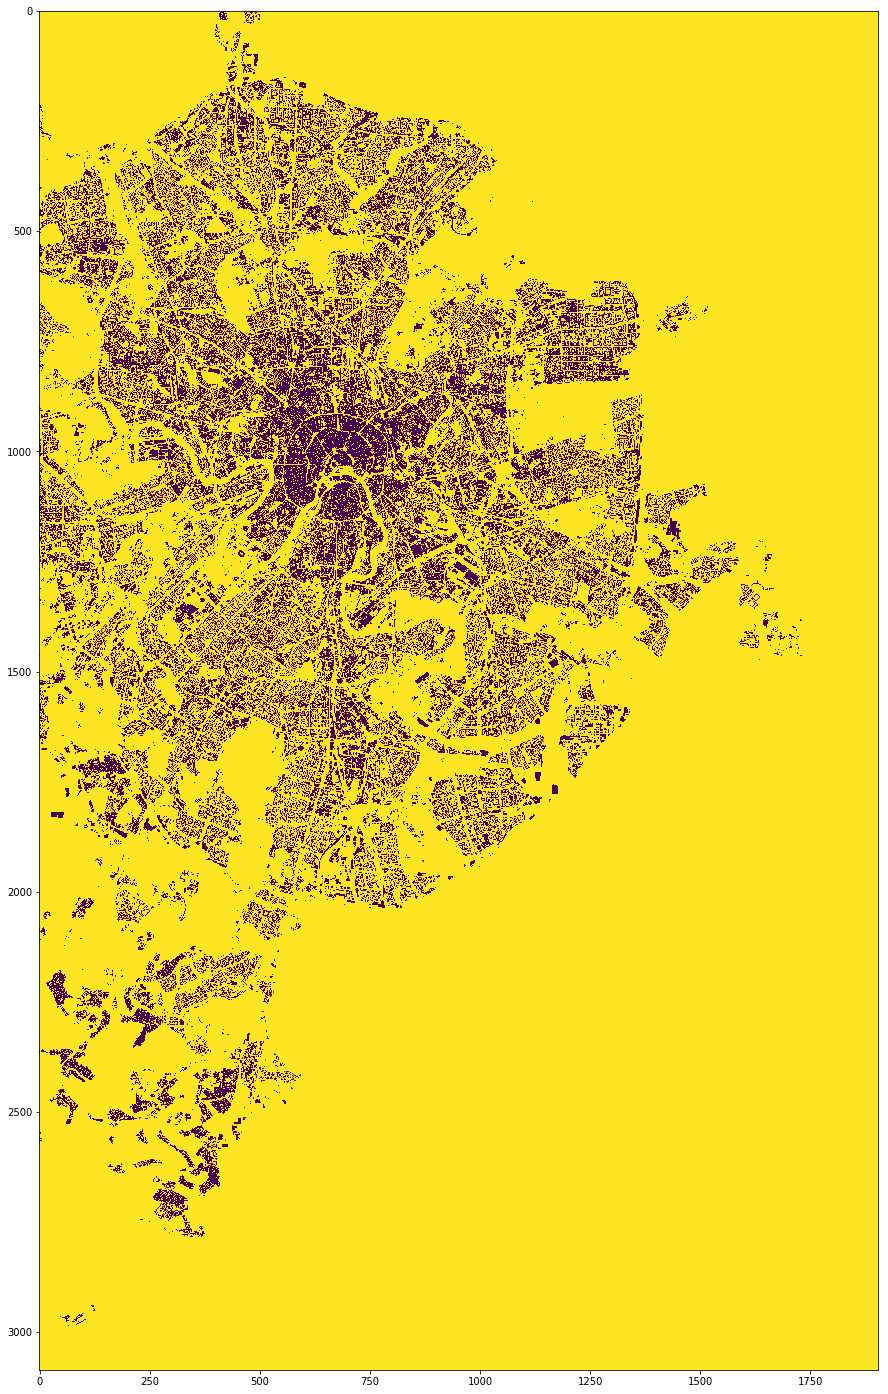

In [71]:
plt.figure(figsize=(25,25))

show(outClip.ReadAsArray())
plt.show()

In [72]:
outClip = None